In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

In [3]:
# Define paths to your data
data_paths = {
    "spiral_control": "C:/Users/ADMIN/Documents/Document/USTH/B3/mlmed/data/Spiral_HandPD/SpiralControl",
    "spiral_patients": "C:/Users/ADMIN/Documents/Document/USTH/B3/mlmed/data/Spiral_HandPD/SpiralPatients",
    "meander_control": "C:/Users/ADMIN/Documents/Document/USTH/B3/mlmed/data/Meander_HandPD/MeanderControl",
    "meander_patients": "C:/Users/ADMIN/Documents/Document/USTH/B3/mlmed/data/Meander_HandPD/MeanderPatients",
}

spiral_controls_path = data_paths["spiral_control"]
meander_patients_path = data_paths["meander_patients"]
spiral_patients_path = data_paths["spiral_patients"]
meander_controls_path = data_paths["meander_control"]

In [8]:
# Function to check for corrupted images and ignore non-image files like .DS_Store
def check_corrupted_images(folder_path):
    corrupted_images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Skip non-image files like .DS_Store
        if not filename.endswith('.jpg') and not filename.endswith('.png'):
            continue
        
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify if the image is valid
        except Exception as e:
            corrupted_images.append((filename, str(e)))
    
    return corrupted_images

# Checking for corrupted images in each folder
corrupted_spiral_controls = check_corrupted_images(spiral_controls_path)
corrupted_spiral_patients = check_corrupted_images(spiral_patients_path)

corrupted_meander_controls = check_corrupted_images(meander_controls_path)
corrupted_meander_patients = check_corrupted_images(meander_patients_path)

print("Corrupted images in MeanderControls:", corrupted_meander_controls)
print("Corrupted images in MeanderPatients:", corrupted_meander_patients)
print("Corrupted images in SpiralControls:", corrupted_spiral_controls)
print("Corrupted images in SpiralPatients:", corrupted_spiral_patients)


Corrupted images in MeanderControls: []
Corrupted images in MeanderPatients: []
Corrupted images in SpiralControls: []
Corrupted images in SpiralPatients: []


In [10]:
# Count the number of images in each folder
num_meander_controls = len(os.listdir(meander_controls_path))
num_meander_patients = len(os.listdir(meander_patients_path))
num_spiral_controls = len(os.listdir(spiral_controls_path))
num_spiral_patients = len(os.listdir(spiral_patients_path))

print("Number of images in spiral_controls:", num_spiral_controls)
print("Number of images in spiral_patients:", num_spiral_patients)
print("Number of images in meander_controls:", num_meander_controls)
print("Number of images in meander_patients:", num_meander_patients)

Number of images in spiral_controls: 73
Number of images in spiral_patients: 297
Number of images in meander_controls: 73
Number of images in meander_patients: 297


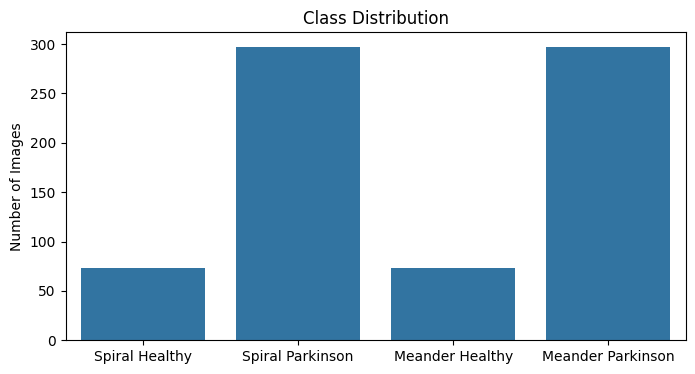

In [11]:
# Plot the class distribution
plt.figure(figsize=(8, 4))
sns.barplot(
    x=["Spiral Healthy", "Spiral Parkinson", "Meander Healthy", "Meander Parkinson"],
    y=[num_spiral_controls, num_spiral_patients, num_meander_controls, num_meander_patients]
)
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()


In [12]:
# Function to display sample images from a folder
def display_sample_images(folder_path, title, num_samples=5):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    num_samples = min(num_samples, len(image_files))

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img_path = os.path.join(folder_path, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title)
    plt.show()


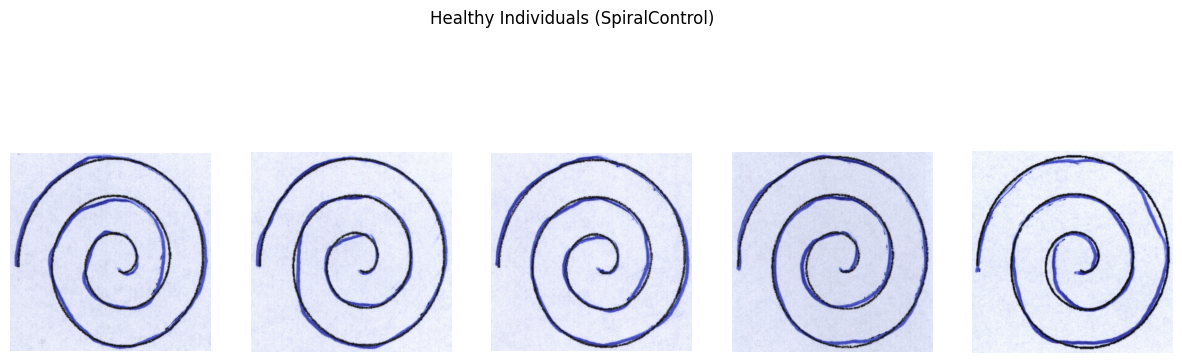

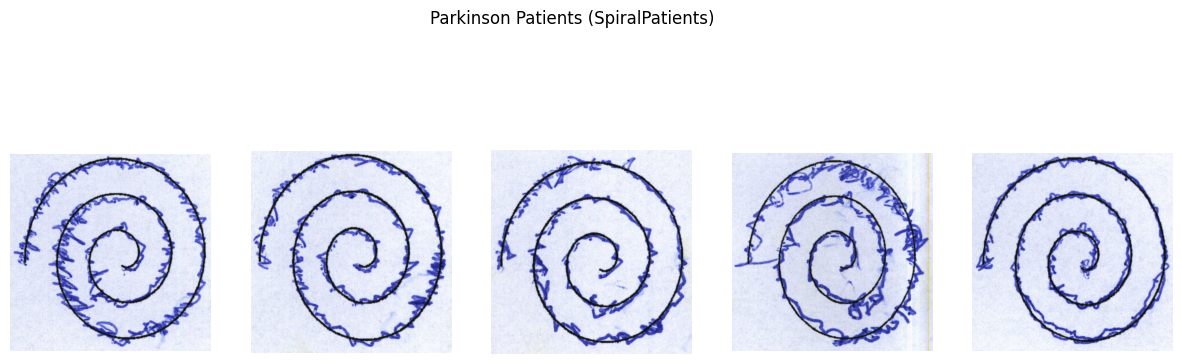

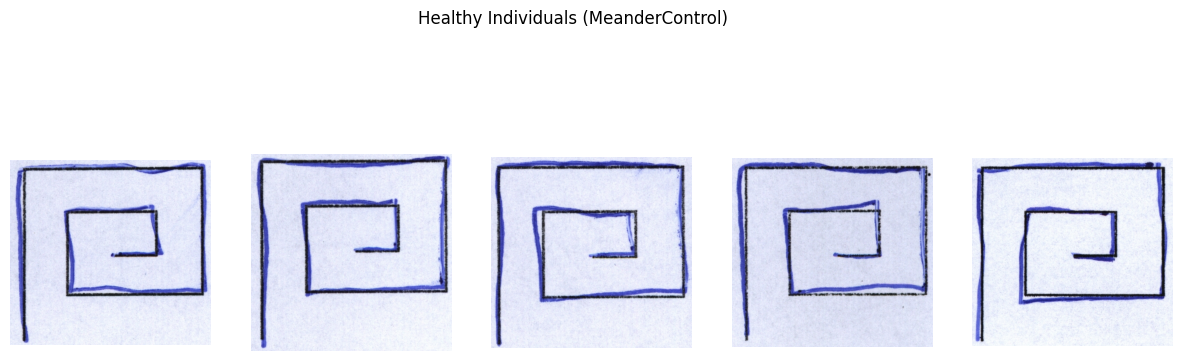

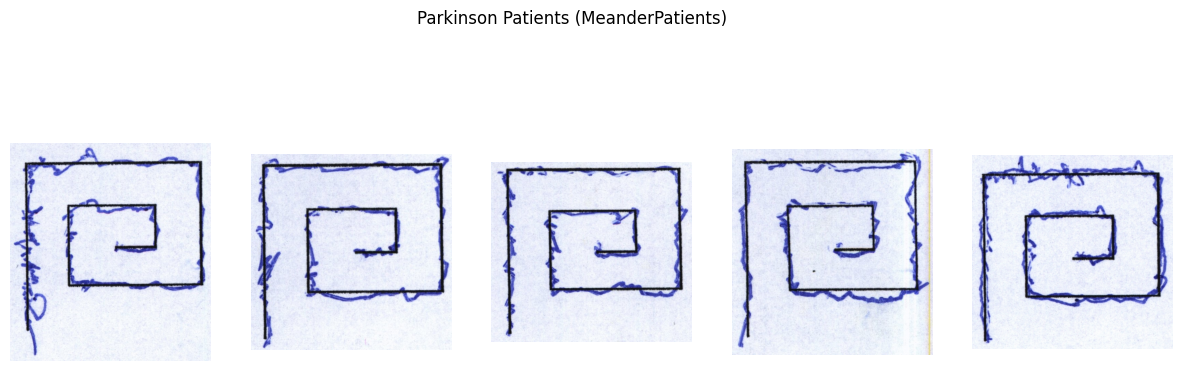

In [14]:
# Display sample images
display_sample_images(spiral_controls_path, "Healthy Individuals (SpiralControl)")
display_sample_images(spiral_patients_path, "Parkinson Patients (SpiralPatients)")
display_sample_images(meander_controls_path, "Healthy Individuals (MeanderControl)")
display_sample_images(meander_patients_path, "Parkinson Patients (MeanderPatients)")

In [15]:
# Label map for the classes
label_map = {
    "spiral_control": 0,
    "spiral_patients": 1,
    "meander_control": 0,
    "meander_patients": 1
}

In [16]:
# Function to load images and labels
def load_and_labels(img_size=(128, 128)):
    images = []
    labels = []
    for folder, label in label_map.items():
        folder_path = data_paths[folder]
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, target_size=img_size, color_mode="rgb")
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
    
    X = np.array(images) / 255.0  # Normalize the images
    y = np.array(labels)
    
    return X, y

In [17]:
# Load images and labels
X, y = load_and_labels(img_size=(128, 128))

# Reshape X for single-channel grayscale if needed
X = X.reshape(-1, 128, 128, 3)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# Build ResNet50V2 model
model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [19]:
# Add custom layers on top of ResNet50V2
from tensorflow.keras import models, layers

model_new = models.Sequential([
    model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Train the model
model_new.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 311ms/step - accuracy: 0.7139 - loss: 0.6562 - val_accuracy: 0.8311 - val_loss: 0.4475
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.8158 - loss: 0.4331 - val_accuracy: 0.8446 - val_loss: 0.3864
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.8555 - loss: 0.4102 - val_accuracy: 0.8176 - val_loss: 0.4141
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.8602 - loss: 0.3290 - val_accuracy: 0.8176 - val_loss: 0.4345
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.8711 - loss: 0.3257 - val_accuracy: 0.7973 - val_loss: 0.3965
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.9011 - loss: 0.2703 - val_accuracy: 0.8243 - val_loss: 0.3994
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.8754 - loss: 0.2360 - val_accuracy: 0.8514 - val_loss: 0.3218
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.9137 - loss: 0.2183 - val_accuracy: 0

In [21]:
# Count the number of files in the training and testing sets
num_train_samples = len(X_train)
num_test_samples = len(X_test)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of testing samples: {num_test_samples}")


Number of training samples: 588
Number of testing samples: 148


In [22]:
# Save the trained model to a file
model_new.save('trained_resnet50v2_model.h5')
print("Model saved to 'trained_resnet50v2_model.h5'")


Model saved to 'trained_resnet50v2_model.h5'
